In [44]:
from database.utils import get_reconstructed_probabilities
from models.SVM.binary_classification import get_best_estimators, get_scores_and_probs, optimise_score_over_channels, manual_y_predict
from models.scoring_metrics import scoring_function, print_scores_for_channel, get_av_confusion_matrix
from database.data import Data
from sklearn.svm import SVC
from tqdm import tqdm
import numpy as np


In [45]:
#creating DATA object
ptb_binary_SVM = Data(database = 'ptbdb', denoise_method='DWT', estimation_method = 'SVM', train_splits=None, binary = True, parameterisation = True)


# define hyperparameter grid to test
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale']#including 'auto' aswell takes forever
}


In [55]:
repeats = 2
best_scores = []
best_channels = []
probs_list = []
y_tests_list = []
nan_indices_list = []
thresholds_list = []
scores = []


for i in tqdm(range(repeats)):

    ptb_binary_SVM.run()


    #define classifier
    svc = SVC(class_weight='balanced', probability = True)

    #find the best set of hyperparameters for each channel, tuned on the desired scoring function
    best_estimators = get_best_estimators(ptb_binary_SVM.selected_features, param_grid, scoring_function, svc, ptb_binary_SVM.health_state, ptb_binary_SVM.nan_indices)

    #perform 3 way skfold to get scores for each channel as well as their probabilities
    n_splits = 3
    all_score_metrics, probabilities, thresholds, y_tests, test_indices = get_scores_and_probs(ptb_binary_SVM.selected_features, ptb_binary_SVM.health_state, ptb_binary_SVM.nan_indices, best_estimators, scoring_function, n_splits)

    #printing scores for each channel
    print_scores_for_channel(all_score_metrics)

    #reconstructing calculated probabilities so can optimise over all channels
    reconstructed_probs = get_reconstructed_probabilities(probabilities, test_indices, ptb_binary_SVM.nan_indices, ptb_binary_SVM.allowed_patients.count_patients(), n_splits)

    #need for ROC curve and confusion matrix later
    probs_list.append(reconstructed_probs)
    nan_indices_list.append(ptb_binary_SVM.nan_indices)
    y_tests_list.append(y_tests)
    thresholds_list.append(thresholds)

    #optimising over channels
    best_score, best_channel_indices = optimise_score_over_channels(reconstructed_probs, thresholds, ptb_binary_SVM.health_state)

    print(best_score, best_channel_indices)

    best_scores.append(best_score)
    best_channels.append(best_channel_indices)


  0%|          | 0/2 [00:00<?, ?it/s]

Filtering Database


100%|██████████| 221/221 [00:01<00:00, 124.18it/s]


denoising signals through Discrete Wavelet Transform
normalising signals
calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['rr_amps', 'mean', 'sd2', 'age']
Selected features for channel 2:
['rr_std', 'rr_amps', 'sd2', 'age']
Selected features for channel 3:
['rr_std', 'sd1', 'sd2', 'age']
Selected features for channel 4:
['rr_amps', 'std', 'lf', 'age']
Selected features for channel 5:
['shannon_en', 'sd1', 'sd2', 'age']
Selected features for channel 6:
['rr_std', 'mean', 'lf', 'age']


 50%|█████     | 1/2 [02:28<02:28, 148.43s/it]

      Success Metric           Channel 1           Channel 2  \
0    Objective Score  0.7281122407978882  0.6920615178436783   
1  Balanced Accuracy  0.7393557422969188  0.7678310417440853   

            Channel 3           Channel 4           Channel 5  \
0  0.7567481569063848  0.7451978479429914  0.7152161632667831   
1  0.7873376623376623  0.6722848535984521  0.7458553791887125   

            Channel 6  
0  0.7387254249361167  
1  0.6987363789250581  
0.8547536231884058 [0, 1, 2, 5]
Filtering Database


100%|██████████| 221/221 [00:00<00:00, 295.84it/s]


denoising signals through Discrete Wavelet Transform
normalising signals
calculating time domain parameters
calculating frequency domain parameters
calculating non linear domain parameters
selecting 4 most important features
Selected features for channel 1:
['rr_amps', 'mean', 'lf', 'age']
Selected features for channel 2:
['rr_amps', 'lf', 'total_power', 'age']
Selected features for channel 3:
['rr_amps', 'sd1', 'sd2', 'age']
Selected features for channel 4:
['rr_amps', 'skews', 'lf', 'age']
Selected features for channel 5:
['skews', 'lf', 'total_power', 'age']
Selected features for channel 6:
['rr_std', 'RMSSD', 'mean', 'age']


100%|██████████| 2/2 [04:14<00:00, 127.06s/it]

      Success Metric           Channel 1           Channel 2  \
0    Objective Score  0.7150618575535765  0.7590652495756763   
1  Balanced Accuracy  0.6758169934640522  0.7271398488789793   

            Channel 3           Channel 4           Channel 5  \
0   0.762209145359933  0.7490237656004121   0.729058234230648   
1  0.7932900432900433  0.6908336806579175  0.7004409171075837   

            Channel 6  
0  0.7374795431229351  
1  0.7415641486396204  
0.8639792728034057 [1, 2, 4, 5]


## ROC CURVE

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#if this breaks it is because the max length of each one will be different so just manually set it too the biggest channel length


average_tprs = []
average_aucs = []

for j in range(repeats):
    channel_fpr = []
    channel_tpr = []
    max_length = 0
    for i in best_channels[j]:
        probs_for_roc = probs_list[j][i][nan_indices_list[j][i]]
        y_tests_combined = np.concatenate(y_tests_list[j][i])
        length = len(y_tests_combined)

        if length > max_length:
            max_length = length


        # computing ROC params
        fpr, tpr, _ = roc_curve(y_tests_combined, probs_for_roc, pos_label='Healthy')

        channel_fpr.append(fpr)
        channel_tpr.append(tpr)


    #need to interpolate everything so they are the desired length
    mean_fpr = np.linspace(0, 1, 200)#put max length of array in here in a sec

    interp_tpr = []
    for i in best_channel_indices:
        interp_tpr.append(np.interp(mean_fpr, fpr, tpr))

    average_tpr = np.mean(interp_tpr, axis=0)

    roc_auc = auc(mean_fpr, average_tpr)

    average_tprs.append(average_tpr)
    average_aucs.append(roc_auc)

mean_tpr = np.mean(average_tprs, axis = 0)
std_tpr = np.std(average_tprs, axis=0)

mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(average_aucs)



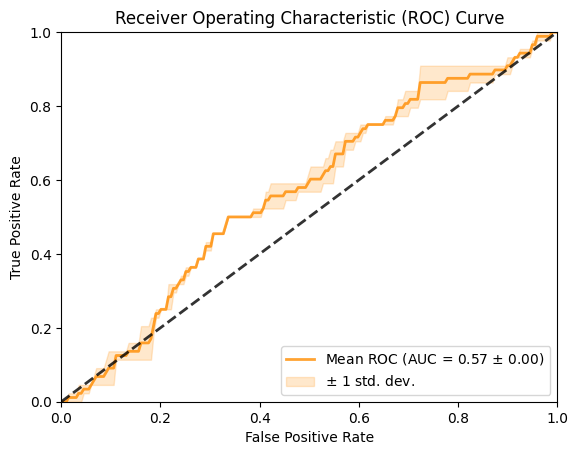

In [58]:
# plotting average ROC curve for all iterations
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='darkorange', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('figures\\ROC_curve.png', bbox_inches='tight')
plt.show()

## Confusion Matrix

In [78]:
manual_y_preds = []
confusion_matrix_list = []
y_tests_combined_list = []
for j in range(repeats):
    for i in best_channels[j]:
        probs = probs_list[j][i][nan_indices_list[j][i]]
        y_tests_combined_list.append(np.concatenate(y_tests_list[j][i]))
        manual_y_preds.append(manual_y_predict(probs, thresholds_list[j][i]))
    confusion_matrix_list.append(get_av_confusion_matrix(y_tests_combined_list, manual_y_preds))
print(confusion_matrix_list)
average_confusion_matrix = np.mean(confusion_matrix_list, axis=0)
print(average_confusion_matrix)


[array([[ 11.5 ,  28.75],
       [ 32.  , 111.25]]), array([[ 10.625,  29.625],
       [ 28.375, 116.125]])]
[[ 11.0625  29.1875]
 [ 30.1875 113.6875]]


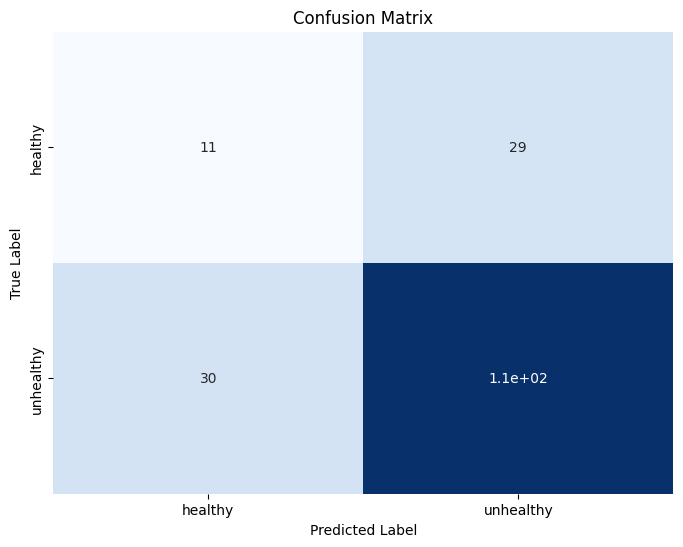

In [83]:
import seaborn as sns

target_names = ['healthy', 'unhealthy']
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))

ax = sns.heatmap(average_confusion_matrix, annot=True, cmap='Blues', cbar=False, 
                 xticklabels=target_names, 
                 yticklabels=target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig('figures\\confusion_matrix.png', bbox_inches='tight')
plt.show()

In [39]:
print(np.mean(best_scores))
print(np.std(best_scores))

print(best_channels)

0.8558429863212471
0.0010893631328414144
[[2, 3, 4, 5], [1, 2, 3, 4, 5]]


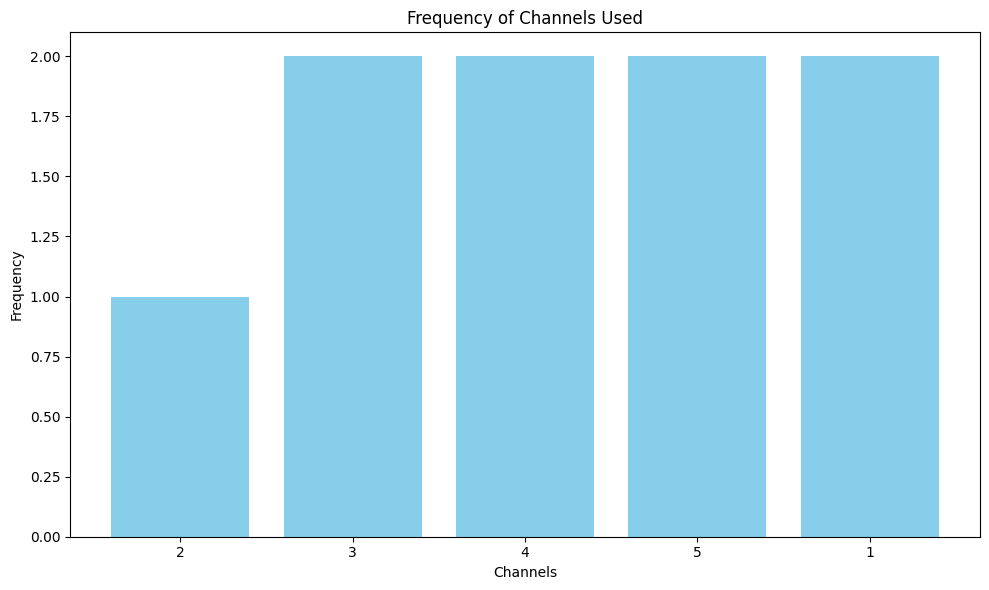

In [41]:
import matplotlib.pyplot as plt
from collections import Counter


# Flatten the list of lists
flattened_list = [number for sublist in best_channels for number in sublist]

# Count the occurrences of each number
counted_numbers = Counter(flattened_list)

# Sort the numbers to maintain a consistent order in the plot
sorted_numbers = sorted(counted_numbers.keys())
counts = [counted_numbers[number] for number in sorted_numbers]

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(sorted_numbers, counts, color='skyblue')

# Adding labels and title
ax.set_xlabel('Channels')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Channels Used')
ax.set_xticks(sorted_numbers)
ax.set_xticklabels(counted_numbers.keys())

# Show the plot
plt.tight_layout()
plt.savefig('figures\\number_frequency_bar_chart.png', bbox_inches='tight')
plt.show()